In [1]:
from collections import defaultdict
from functools import partial
import json
from pathlib import Path
import random
import re
import sys

from google.cloud import storage
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import polaris as po
from tqdm import tqdm
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors
from rdkit.Chem import MACCSkeys
from rdkit import DataStructs
from rdkit import RDLogger
import seaborn as sns
import vertexai
from vertexai.generative_models import GenerativeModel, GenerationConfig
from vertexai.tuning import sft

sys.path.insert(0, '../agenticadmet')
from eval import extract_preds

[13:46:03] Initializing Normalizer


In [2]:
logger = RDLogger.logger()
logger.setLevel(RDLogger.CRITICAL)

In [3]:
PROJECT_ID = "bioptic-io"
LOCATION = "us-central1"
vertexai.init(project=PROJECT_ID, location=LOCATION)

RANDOM_SEED = 42

In [4]:
TARGET_COLUMNS = ["HLM", "MLM", "LogD", "KSOL", "MDR1-MDCKII"]
PROPERTIES = ['LogHLM', 'LogMLM', 'LogD', 'LogKSOL', 'LogMDR1-MDCKII']
TOPK_TARGET_DATA = 5
TOPK_EXTERNAL_DATA = 3
INTERNAL_PROPERTIES = PROPERTIES
EXTERNAL_PROPERTIES = ['LOG_HLM_CLint', 'LOG_RLM_CLint', 'LOG_MDR1-MDCK_ER', 'LOG_HPPB', 'LOG_RPPB', 'LOG_SOLUBILITY']

In [5]:
train = pd.read_csv(f'../data/asap/preproc/train_clean.tsv', sep='\t')
train

,smiles,HLM,KSOL,LogD,MLM,MDR1-MDCKII,smiles_std,cxsmiles_std,mol_idx,smiles_ext,LogHLM,LogMLM,LogKSOL,LogMDR1-MDCKII
0,COC1=CC=CC(Cl)=C1NC(=O)N1CCC[C@H](C(N)=O)C1 |a...,NaN,NaN,0.3,NaN,2.0,COc1cccc(Cl)c1NC(=O)N1CCC[C@H](C(N)=O)C1,COc1cccc(Cl)c1NC(=O)N1CCC[C@H](C(N)=O)C1 |a:16|,191,|a:16|,NaN,NaN,NaN,0.477121
1,O=C(NCC(F)F)[C@H](NC1=CC2=C(C=C1Br)CNC2)C1=CC(...,NaN,333.0,2.9,NaN,0.2,O=C(NCC(F)F)[C@H](Nc1cc2c(cc1Br)CNC2)c1cc(Cl)c...,O=C(NCC(F)F)[C@H](Nc1cc2c(cc1Br)CNC2)c1cc(Cl)c...,335,|&1:7|,NaN,NaN,2.523746,0.079181
2,O=C(NCC(F)F)[C@H](NC1=CC=C2CNCC2=C1)C1=CC(Br)=...,NaN,NaN,0.4,NaN,0.5,O=C(NCC(F)F)[C@H](Nc1ccc2c(c1)CNC2)c1cc(Br)cc2...,O=C(NCC(F)F)[C@H](Nc1ccc2c(c1)CNC2)c1cc(Br)cc2...,336,|&1:7|,NaN,NaN,NaN,0.176091
3,NC(=O)[C@H]1CCCN(C(=O)CC2=CC=CC3=C2C=CO3)C1 |&...,NaN,376.0,1.0,NaN,8.5,NC(=O)[C@H]1CCCN(C(=O)Cc2cccc3occc23)C1,NC(=O)[C@H]1CCCN(C(=O)Cc2cccc3occc23)C1 |&1:3|,300,|&1:3|,NaN,NaN,2.576341,0.977724
4,CC1=CC(CC(=O)N2CCC[C@H](C(N)=O)C2)=CC=N1 |&1:11|,NaN,375.0,-0.3,NaN,0.9,Cc1cc(CC(=O)N2CCC[C@H](C(N)=O)C2)ccn1,Cc1cc(CC(=O)N2CCC[C@H](C(N)=O)C2)ccn1 |&1:11|,249,|&1:11|,NaN,NaN,2.575188,0.278754
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399,CC(C)NC[C@H](O)COC1=CC=CC2=CC=CC=C12 |&1:5|,25.5,NaN,NaN,63.0,NaN,CC(C)NC[C@H](O)COc1cccc2ccccc12,CC(C)NC[C@H](O)COc1cccc2ccccc12 |&1:5|,22,|&1:5|,1.423246,1.806180,NaN,NaN
400,O=C(O)CC1=CC=CC=C1NC1=C(Cl)C=CC=C1Cl,216.0,NaN,NaN,386.0,NaN,O=C(O)Cc1ccccc1Nc1c(Cl)cccc1Cl,O=C(O)Cc1ccccc1Nc1c(Cl)cccc1Cl,380,NaN,2.336460,2.587711,NaN,NaN
401,NCC1=CC(Cl)=CC(C(=O)NC2=CC=C3CNCC3=C2)=C1,NaN,NaN,2.0,NaN,NaN,NCc1cc(Cl)cc(C(=O)Nc2ccc3c(c2)CNC3)c1,NCc1cc(Cl)cc(C(=O)Nc2ccc3c(c2)CNC3)c1,303,NaN,NaN,NaN,NaN,NaN
402,COC(=O)NC1=NC2=CC=C(C(=O)C3=CC=CC=C3)C=C2N1,NaN,NaN,2.9,NaN,NaN,COC(=O)Nc1nc2ccc(C(=O)c3ccccc3)cc2[nH]1,COC(=O)Nc1nc2ccc(C(=O)c3ccccc3)cc2[nH]1,166,NaN,NaN,NaN,NaN,NaN


In [6]:
test = pd.read_csv('../data/asap/preproc/test.tsv', sep='\t')
test

,smiles,smiles_std,cxsmiles_std
0,CC(C)[C@H]1C2=C(CCN1C(=O)CC1=CN=CC3=CC=CC=C13)...,CC(C)[C@H]1c2ccsc2CCN1C(=O)Cc1cncc2ccccc12,CC(C)[C@H]1c2ccsc2CCN1C(=O)Cc1cncc2ccccc12 |o1:3|
1,CC(C)C1(C)CCN(C(=O)CC2=CN=CC3=CC=CC=C23)CC1,CC(C)C1(C)CCN(C(=O)Cc2cncc3ccccc23)CC1,CC(C)C1(C)CCN(C(=O)Cc2cncc3ccccc23)CC1
2,O=C(CC1=CN=CC2=CC=CC=C12)N1CCC2=C(C=CS2)C12CCC2,O=C(Cc1cncc2ccccc12)N1CCc2sccc2C12CCC2,O=C(Cc1cncc2ccccc12)N1CCc2sccc2C12CCC2
3,CC1(CC(F)(F)F)CCN(C(=O)CC2=CN=CC3=CC=CC=C23)CC1,CC1(CC(F)(F)F)CCN(C(=O)Cc2cncc3ccccc23)CC1,CC1(CC(F)(F)F)CCN(C(=O)Cc2cncc3ccccc23)CC1
4,CCC1=CC=C([C@H]2C[C@H](C)CCN2C(=O)CC2=CN=CC3=C...,CCc1ccc([C@H]2C[C@H](C)CCN2C(=O)Cc2cncc3ccccc2...,CCc1ccc([C@H]2C[C@H](C)CCN2C(=O)Cc2cncc3ccccc2...
...,...,...,...
121,C[C@H]1CN(C2=CN=CC3=CC=CC=C23)C(=O)[C@@]12CN(C...,C[C@H]1CN(c2cncc3ccccc23)C(=O)[C@@]12CN(Cc1ccn...,C[C@H]1CN(c2cncc3ccccc23)C(=O)[C@@]12CN(Cc1ccn...
122,C[C@H]1CN(C2=CN=CC3=CC=CC=C23)C(=O)[C@@]12CN(C...,C[C@H]1CN(c2cncc3ccccc23)C(=O)[C@@]12CN(Cc1cnn...,C[C@H]1CN(c2cncc3ccccc23)C(=O)[C@@]12CN(Cc1cnn...
123,COC[C@H]1CN(C2=CN=CC3=CC=CC=C23)C(=O)[C@@]12CN...,COC[C@H]1CN(c2cncc3ccccc23)C(=O)[C@@]12CN(Cc1c...,COC[C@H]1CN(c2cncc3ccccc23)C(=O)[C@@]12CN(Cc1c...
124,C[C@H]1CN(C2=CN=CC3=CC=CC=C23)C(=O)[C@@]12CN(C...,C[C@H]1CN(c2cncc3ccccc23)C(=O)[C@@]12CN(CCN1CC...,C[C@H]1CN(c2cncc3ccccc23)C(=O)[C@@]12CN(CCN1CC...


In [7]:
external_data = pd.read_csv('../data/asap/preproc/biogen-adme-fang-v1-std.tsv', sep='\t')
external_data

,UNIQUE_ID,MOL_smiles,SMILES,LOG_HLM_CLint,LOG_RLM_CLint,LOG_MDR1-MDCK_ER,LOG_HPPB,LOG_RPPB,LOG_SOLUBILITY,smiles_std
0,b5e1231aef0080c76b4207ca1355485432877339,Brc1cc2c(cc1Cn1cncn1)OCCCO2,Brc1cc2c(cc1Cn1cncn1)OCCCO2,0.886265,2.357933,-0.247518,NaN,NaN,1.536432,Brc1cc2c(cc1Cn1cncn1)OCCCO2
1,0604cf74e44450d5963d169e18854d96c4e5dba8,Brc1ccc(-c2nnc(Cn3cnc4ccccc43)o2)o1,Brc1ccc(-c2nnc(Cn3cnc4ccccc43)o2)o1,0.675687,1.613704,-0.010669,NaN,NaN,1.797475,Brc1ccc(-c2nnc(Cn3cnc4ccccc43)o2)o1
2,c518badac8533fdb0de4679c17ce4035eab9ac28,Brc1cnc(N2CCCN(c3ccccc3)CC2)nc1,Brc1cnc(N2CCCN(c3ccccc3)CC2)nc1,2.081607,3.753651,NaN,NaN,NaN,NaN,Brc1cnc(N2CCCN(c3ccccc3)CC2)nc1
3,9be43035e7b8a5078babf4345584f4dc6dcd1448,Brc1cnc2ccccc2c1,Brc1cnc2ccccc2c1,NaN,NaN,NaN,NaN,NaN,-0.033858,Brc1cnc2ccccc2c1
4,57b907f2f455c3ce3ba21114f32f93b301c99a34,Brc1nnc(N2CCC(OC3CCCC3)CC2)s1,Brc1nnc(N2CCC(OC3CCCC3)CC2)s1,1.888410,3.492201,-0.235024,NaN,NaN,NaN,Brc1nnc(N2CCC(OC3CCCC3)CC2)s1
...,...,...,...,...,...,...,...,...,...,...
3512,6170f36d417c6cebd1a98e82f03005da39ccc983,c1nc(N2CCC3(CCCCC3)C2)c2cn[nH]c2n1,c1nc(N2CCC3(CCCCC3)C2)c2cn[nH]c2n1,0.920801,2.851225,-0.096904,NaN,NaN,NaN,c1nc(N2CCC3(CCCCC3)C2)c2cn[nH]c2n1
3513,644313d1941ab4550760b7c1162c54d209a7435f,c1nc(NC2CCN(C3CC3)CC2)c2sccc2n1,c1nc(NC2CCN(C3CC3)CC2)c2sccc2n1,1.240899,1.906157,0.094514,NaN,NaN,1.749891,c1nc(NC2CCN(C3CC3)CC2)c2sccc2n1
3514,32658afab9952faf20249dbb305e1ac85ef10a1b,c1nc(Nc2ccc3c(c2)OCCCO3)c2sccc2n1,c1nc(Nc2ccc3c(c2)OCCCO3)c2sccc2n1,1.964066,3.196559,NaN,NaN,NaN,1.707229,c1nc(Nc2ccc3c(c2)OCCCO3)c2sccc2n1
3515,de4a8fd15738b6f012f58b93bb6784afc82f9742,c1nn(C2CCOCC2)cc1Nc1ncc2nnn(-c3ccc4cn[nH]c4c3)...,c1nn(C2CCOCC2)cc1Nc1ncc2nnn(-c3ccc4cn[nH]c4c3)...,1.985754,2.883853,2.725057,NaN,NaN,NaN,c1nn(C2CCOCC2)cc1Nc1ncc2nnn(-c3ccc4cn[nH]c4c3)...


In [8]:
def save_and_upload_training_data(data, path, gs_uri):
    with open(path, 'w') as f:
        for item in data:
            f.write(json.dumps(item) + '\n')

    storage_client = storage.Client()
    bucket_name, key = gs_uri[5:].split("/", 1)
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(key)
    blob.upload_from_filename(path)

In [9]:
def start_finetuning_sft(
        train_dataset_gs_uri: str, val_dataset_gs_uri: str | None = None, source_model: str = "gemini-1.5-pro-002",
        adapter_size: int = 4, epochs: int = 10, tuned_model_display_name: str | None = None
    ):
    sft_tuning_job = sft.train(
        source_model=source_model,
        train_dataset=train_dataset_gs_uri,
        validation_dataset=val_dataset_gs_uri,
        adapter_size=adapter_size,
        epochs=epochs,
        tuned_model_display_name=tuned_model_display_name
    )

In [10]:
def get_answer(model, content):
    result = model.generate_content(content['contents'])
    candidate_properties = defaultdict(list)
    for candidate in result.candidates:
        answer = candidate.content.parts[0].text
        try:
            # Extract all property=value pairs from the answer
            matches = re.findall(r'(\w+(?:-\w+)*?)=(-?\d+\.\d+)', answer.strip())
            if not matches:
                print(answer)
                return None
                
            # Convert to dictionary
            for prop, val in matches:
                candidate_properties[prop].append(float(val))
            
        except Exception as e:
            print(answer)
            return None

    answer = {
        prop: np.mean(candidate_properties[prop]) for prop in PROPERTIES
    }
    # reorder to match PROPERTIES
    answer = {prop: answer[prop] for prop in PROPERTIES if prop in answer}

    return answer

In [11]:
def maccs_similarity_matrix(queries, references):
    query_fps = [MACCSkeys.GenMACCSKeys(Chem.MolFromSmiles(s)) for s in queries]
    ref_fps = [MACCSkeys.GenMACCSKeys(Chem.MolFromSmiles(s)) for s in references]

    dist_mat = np.array([
        DataStructs.BulkTanimotoSimilarity(query_fp, ref_fps)
        for query_fp in query_fps
    ])
    
    return dist_mat

def extract_properties_v3(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return ""
    
    properties = {}

    # --- Basic RDKit Descriptors ---
    properties["MW"] = Descriptors.MolWt(mol)
    properties["RotB"] = Descriptors.NumRotatableBonds(mol)
    properties["TPSA"] = rdMolDescriptors.CalcTPSA(mol)
    properties["HBD"] = Descriptors.NumHDonors(mol)
    properties["HBA"] = Descriptors.NumHAcceptors(mol)
    properties["LogP"] = Descriptors.MolLogP(mol)
    
    # --- Ring Counts ---
    properties["aroma"] = rdMolDescriptors.CalcNumAromaticRings(mol)
    properties["alipha"] = rdMolDescriptors.CalcNumAliphaticRings(mol)

    properties = ", ".join([
        f"{prop_name}={int(prop_val)}" if prop_name != "LogP" else f"{prop_name}={prop_val:.2f}"
        for prop_name, prop_val in properties.items()
    ])

    return properties

In [12]:
ref_data = pd.concat([train, external_data]).reset_index(drop=True)
train2ref_dist = maccs_similarity_matrix(train['smiles_std'], ref_data['smiles_std'])
test2ref_dist = maccs_similarity_matrix(test['smiles_std'], ref_data['smiles_std'])
train2ref_dist.shape, test2ref_dist.shape

((404, 3921), (126, 3921))

In [13]:
def get_all_topk_smiles_with_properties(
        ref_data, query_data, query2ref_dist,
        topk_target=TOPK_TARGET_DATA, topk_external=TOPK_EXTERNAL_DATA, randomize=False, is_test=False
    ):
    for i in range(query2ref_dist.shape[0]):
        query_smiles = query_data.iloc[i]['smiles_std']
        query_properties = {}
        topk_smiles2properties = defaultdict(dict)
        topk_smiles2rdkit = defaultdict(str)
        topk_smiles2dist = defaultdict(float)
        for property in INTERNAL_PROPERTIES + EXTERNAL_PROPERTIES:
            if property in INTERNAL_PROPERTIES:
                topk = topk_target
            else:
                topk = topk_external
            
            if property in INTERNAL_PROPERTIES and not is_test:
                query_property = query_data.iloc[i][property]
                if not np.isnan(query_property):
                    if randomize:
                        query_property = query_property + random.gauss(0., 0.02)
                    query_properties[property] = query_property

            ref_data_with_property = ref_data[ref_data[property].notna()]
            dist = query2ref_dist[i, ref_data_with_property.index]
            order = np.argsort(dist)[::-1]
            ordered_dist = dist[order]
            if not is_test:
                order = order[~np.isclose(ordered_dist, 1.0)]   # remove self-similarity including duplicates
            topk_idx = order[:topk]
            topk_dist = dist[topk_idx]
            topk_smiles = ref_data_with_property.iloc[topk_idx]['smiles_std'].tolist()
            topk_properties = ref_data_with_property.iloc[topk_idx][property].tolist()

            for smi, prop in zip(topk_smiles, topk_properties):
                if randomize:
                    prop = prop + random.gauss(0., 0.02)
                topk_smiles2properties[smi][property] = prop

            for smi, dist_ in zip(topk_smiles, topk_dist):
                topk_smiles2rdkit[smi] = extract_properties_v3(smi)
                topk_smiles2dist[smi] = dist_
            
        query_rdkit = extract_properties_v3(query_smiles)
        
        yield topk_smiles2properties, topk_smiles2rdkit, topk_smiles2dist, query_smiles, query_rdkit, query_properties

In [14]:
def format_data(
    topk_smiles2properties: dict[str, dict[str, float]],
    topk_smiles2rdkit: dict[str, str],
    topk_smiles2dist: dict[str, float],
    query_smiles: str,
    query_rdkit: str,
    query_properties: dict[str, float] | None = None,
    system_instruction: str | None = None
):
    if system_instruction is not None:
        output = {
            "systemInstruction": {
            "parts": [
            {
                "text": system_instruction
            }
            ]
        }
    }
    else:
        output = {}

    parts = [
        {
            "text": "; ".join([
                f"SMILES: {smi}, " + \
                f"{topk_smiles2rdkit[smi]}, " + \
                f"Similarity: {topk_smiles2dist[smi]:.2f}, " + \
                ", ".join([
                    f"{prop_name}={prop_val:.2f}"
                    for prop_name, prop_val in prop_name2prop_val.items()
                ])
                for smi, prop_name2prop_val in topk_smiles2properties.items()
            ])
        }
    ]
    if query_properties is not None:
        parts.append({
            "text": f"SMILES: {query_smiles}, {query_rdkit}; " + "Determine " + ", ".join([
                f"{prop_name}" for prop_name in query_properties.keys()
            ])
        })
    else:
        parts.append({
            "text": f"SMILES: {query_smiles}, {query_rdkit}; " + "Determine " +", ".join([
                f"{prop_name}" for prop_name in PROPERTIES
            ])
        })
    
    output.update({
        "contents": [
            {
            "role": "user",
            "parts": parts
            }
        ]
    })

    if query_properties is not None:
        output['contents'].append({
            "role": "model",
            "parts": [
                {
                    "text": ", ".join([
                        f"{prop_name}={prop_val:.2f}"
                        for prop_name, prop_val in query_properties.items()
                    ])
                }
            ]
        })
    
    return output

In [15]:
random.seed(RANDOM_SEED)
train_dataset = [
    format_data(
        topk_smiles2properties=topk_smiles2properties,
        topk_smiles2rdkit=topk_smiles2rdkit,
        topk_smiles2dist=topk_smiles2dist,
        query_smiles=query_smiles,
        query_rdkit=query_rdkit,
        query_properties=query_properties
    )
    for _ in range(10)
    for topk_smiles2properties, topk_smiles2rdkit, topk_smiles2dist, query_smiles, query_rdkit, query_properties in 
        get_all_topk_smiles_with_properties(
        ref_data=ref_data,
        query_data=train,
        query2ref_dist=train2ref_dist,
        topk_target=TOPK_TARGET_DATA,
        topk_external=TOPK_EXTERNAL_DATA,
        randomize=True
    )
]

In [16]:
train_dataset[0]

{'contents': [{'role': 'user',
   'parts': [{'text': 'SMILES: O=C1c2ccc(Cl)cc2[C@@]2(CN1CCN1CCOCC1)C(=O)N(c1cncc3ccccc13)C[C@@H]2CNc1ncccn1, MW=598, RotB=7, TPSA=103, HBD=1, HBA=8, LogP=3.48, aroma=4, alipha=3, Similarity: 0.67, LogHLM=2.03, LogMLM=2.10, LogD=1.92, LogKSOL=2.59, LogMDR1-MDCKII=0.33; SMILES: CO[C@@H](C)CN1C[C@H](C(=O)Nc2cncc3ccccc23)c2cc(Cl)ccc2C1=O, MW=423, RotB=5, TPSA=71, HBD=1, HBA=4, LogP=4.10, aroma=3, alipha=1, Similarity: 0.66, LogHLM=2.06, LogMLM=2.75, LogD=2.21, LogKSOL=2.60, LogMDR1-MDCKII=0.99; SMILES: CNC(=O)CN1C[C@@]2(C(=O)N(c3cncc4ccccc34)C[C@@H]2CNc2cnccn2)c2cc(Cl)ccc2C1=O, MW=556, RotB=6, TPSA=120, HBD=2, HBA=7, LogP=2.89, aroma=4, alipha=2, Similarity: 0.66, LogHLM=1.82, LogMLM=2.00, LogD=1.89, LogMDR1-MDCKII=0.32; SMILES: CNC(=O)CN1C[C@@]2(C(=O)N(c3cncc4ccccc34)C[C@@H]2CNc2ccncn2)c2cc(Cl)ccc2C1=O, MW=556, RotB=6, TPSA=120, HBD=2, HBA=7, LogP=2.89, aroma=4, alipha=2, Similarity: 0.66, LogHLM=1.67, LogMLM=1.74, LogD=1.60, LogMDR1-MDCKII=0.49; SMILES: CN

In [17]:
test_dataset = [
    format_data(
        topk_smiles2properties=topk_smiles2properties,
        topk_smiles2rdkit=topk_smiles2rdkit,
        topk_smiles2dist=topk_smiles2dist,
        query_smiles=query_smiles,
        query_rdkit=query_rdkit
    )
    for topk_smiles2properties, topk_smiles2rdkit, topk_smiles2dist, query_smiles, query_rdkit, query_properties in 
        get_all_topk_smiles_with_properties(
        ref_data=ref_data,
        query_data=test,
        query2ref_dist=test2ref_dist,
        topk_target=TOPK_TARGET_DATA,
        topk_external=TOPK_EXTERNAL_DATA,
        is_test=True
    )
]

In [18]:
test_dataset[0]

{'contents': [{'role': 'user',
   'parts': [{'text': 'SMILES: CC1CCC2(CC1)CCN(C(=O)Cc1cncc3ccccc13)C2, MW=322, RotB=2, TPSA=33, HBD=0, HBA=2, LogP=4.21, aroma=2, alipha=2, Similarity: 0.73, LogHLM=2.54, LogMLM=2.36, LogD=3.80, LogKSOL=2.59, LogMDR1-MDCKII=1.28; SMILES: c1ccc2sc(C3CCN(Cc4c[nH]c5ccccc45)CC3)nc2c1, MW=347, RotB=3, TPSA=31, HBD=1, HBA=3, LogP=5.16, aroma=4, alipha=1, Similarity: 0.62, LogHLM=1.59; SMILES: C=CC(=O)N1CCCc2c1cccc2N(Cc1cccc(Cl)c1)C(=O)Cc1cncc2ccccc12, MW=496, RotB=6, TPSA=53, HBD=0, HBA=3, LogP=6.13, aroma=4, alipha=1, Similarity: 0.61, LogHLM=3.21, LogMLM=3.16, LogD=3.30; SMILES: C=CC(=O)N1CCCc2ccc(N(Cc3cccc(Cl)c3)C(=O)Cc3cncc4c(F)cccc34)cc21, MW=514, RotB=6, TPSA=53, HBD=0, HBA=3, LogP=6.27, aroma=4, alipha=1, Similarity: 0.60, LogHLM=2.88, LogMLM=3.28; SMILES: C=CC(=O)N1CCCc2ccc(N(Cc3cccc(C(F)(F)F)c3)C(=O)Cc3cncc4ccccc34)cc21, MW=529, RotB=6, TPSA=53, HBD=0, HBA=3, LogP=6.49, aroma=4, alipha=1, Similarity: 0.60, LogHLM=2.79, LogMLM=3.33; SMILES: O=C1NC(=O)[

In [19]:
data_dir = Path(f"../data/asap/datasets/submit/")
data_dir.mkdir(parents=True, exist_ok=True)
train_data_path = data_dir / f"gemini_all_prop_rnd_reg_maccs_rdkit_top{TOPK_TARGET_DATA}target_{TOPK_EXTERNAL_DATA}ext_train.jsonl"
train_gs_uri = f"<gs_bucket>/data/asap/datasets/submit/gemini_all_prop_rnd_reg_maccs_rdkit_top{TOPK_TARGET_DATA}target_{TOPK_EXTERNAL_DATA}ext_train.jsonl"

save_and_upload_training_data(train_dataset, train_data_path, train_gs_uri)

In [20]:
start_finetuning_sft(
    train_dataset_gs_uri=train_gs_uri,
    source_model="gemini-1.5-flash-002", epochs=2,
    tuned_model_display_name=train_data_path.stem
)

Creating SupervisedTuningJob
SupervisedTuningJob created. Resource name: projects/199759238457/locations/us-central1/tuningJobs/7889406064309829632
To use this SupervisedTuningJob in another session:
tuning_job = sft.SupervisedTuningJob('projects/199759238457/locations/us-central1/tuningJobs/7889406064309829632')
View Tuning Job:
https://console.cloud.google.com/vertex-ai/generative/language/locations/us-central1/tuning/tuningJob/7889406064309829632?project=199759238457


In [21]:
TUNING_JOB_ID = "7889406064309829632"   # 2 epochs
# TUNING_JOB_ID = "8276856369752047616"   # 3 epochs
sft_tuning_job = sft.SupervisedTuningJob(f"projects/{PROJECT_ID}/locations/{LOCATION}/tuningJobs/{TUNING_JOB_ID}")
tuned_model = GenerativeModel(
    sft_tuning_job.tuned_model_endpoint_name,
    generation_config=GenerationConfig(
        temperature=0.5,
        candidate_count=8,
        seed=RANDOM_SEED
    )
)

In [22]:
predictions = list(tqdm(map(partial(get_answer, tuned_model), test_dataset), total=len(test_dataset)))
predictions = pd.DataFrame(predictions).rename(columns={prop: f'pred_{prop}' for prop in PROPERTIES})
test_ = pd.concat([test, predictions], axis=1)

100%|██████████| 126/126 [02:38<00:00,  1.26s/it]


In [23]:
for target in TARGET_COLUMNS:
    if target == 'LogD':
        continue
    test_[f'pred_{target}'] = np.power(10, test_[f'pred_Log{target}']) - 1.

In [24]:
def plot_distributions(data, columns):
    fig, ax = plt.subplots(1, 5, figsize=(15, 3))
    for i, col in enumerate(columns):
        sns.histplot(data[col], ax=ax[i])
        ax[i].set_title(col)
    plt.tight_layout()
    plt.show()

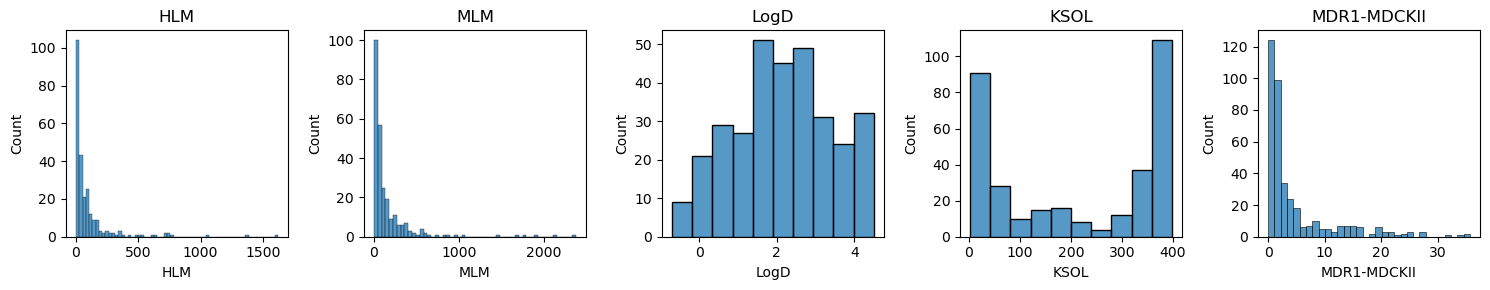

In [25]:
plot_distributions(train, ['HLM', 'MLM', 'LogD', 'KSOL', 'MDR1-MDCKII'])

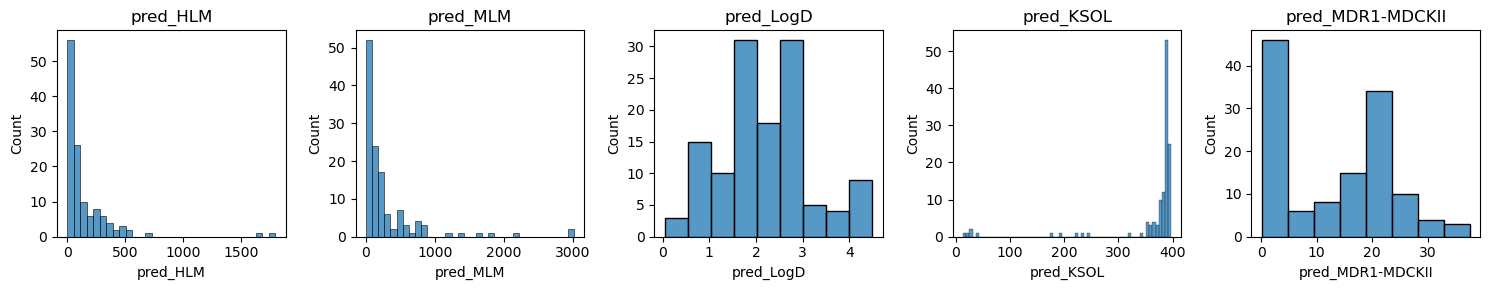

In [26]:
plot_distributions(test_, ['pred_HLM', 'pred_MLM', 'pred_LogD', 'pred_KSOL', 'pred_MDR1-MDCKII'])

In [27]:
y_pred = extract_preds(test_)
print(y_pred.keys())

dict_keys(['HLM', 'MLM', 'LogD', 'KSOL', 'MDR1-MDCKII'])


In [28]:
competition = po.load_competition(f"asap-discovery/antiviral-admet-2025")
competition.target_cols

[2025-03-14 14:37:51] INFO     The version of Polaris that was used to create the artifact (0.11.0) ]8;id=429950;file:///opt/conda/envs/admet/lib/python3.11/site-packages/polaris/_artifact.py\_artifact.py]8;;\:]8;id=655982;file:///opt/conda/envs/admet/lib/python3.11/site-packages/polaris/_artifact.py#92\92]8;;\
                               is different from the currently installed version of Polaris                        
                               (0.11.9).                                                                           

                      WARNING  You're loading data from a remote location. If the dataset is small     ]8;id=628797;file:///opt/conda/envs/admet/lib/python3.11/site-packages/polaris/dataset/_base.py\_base.py]8;;\:]8;id=909880;file:///opt/conda/envs/admet/lib/python3.11/site-packages/polaris/dataset/_base.py#181\181]8;;\
                               enough, consider caching the dataset first using                                    
                               CompetitionSpecification.cache() for more performant data access.                   

{'HLM', 'KSOL', 'LogD', 'MDR1-MDCKII', 'MLM'}

In [30]:
competition.submit_predictions(
    predictions=y_pred,
    prediction_name="LLMs-will-rule-the-world",
    prediction_owner="vladvin",
    report_url="https://docs.google.com/document/d/16y9EtElTmJ-p0bAYjJaNgkU8WP-CYz77lhHB2oxkTc4/edit?usp=sharing",
    # The below metadata is optional, but recommended.
    github_url="https://github.com/Alicegaz/AgenticADMET",
    description="A pure single fine-tuned LLM solution, no ensembling",
    tags=["ADMET", "LLM", "Agentic ADMET"],
    user_attributes={"Framework": "Gemini", "Method": "SFT"}
)

Output()

[14:44:02]  Success: Submitting competition predictions                                               ]8;id=964287;file:///opt/conda/envs/admet/lib/python3.11/site-packages/polaris/utils/context.py\context.py]8;;\:]8;id=130830;file:///opt/conda/envs/admet/lib/python3.11/site-packages/polaris/utils/context.py#53\53]8;;\